In [117]:
from pyspark.sql import functions as F

In [118]:
def readCSV(file, debug=False):
    if debug: print('Reading ' + file)
    return spark.read.csv(file, inferSchema=True, header=True)

In [119]:
path = './EVENTS_1000000.csv'

df = readCSV(path)

In [97]:
from datetime import datetime
from pyspark.sql.functions import col,udf
from pyspark.sql.types import FloatType

myfunc = udf(lambda x: x.timestamp())

df = df.withColumn('Date_time', myfunc(col('CHARTTIME')))
df = df.withColumn('Date_time', df['Date_time'].cast(FloatType()))
df.select(df["Date_time"]).show(5)

+-----------+
|  Date_time|
+-----------+
|5.1867182E9|
|5.1867182E9|
|5.1867182E9|
|5.1867182E9|
|5.1867182E9|
+-----------+
only showing top 5 rows



In [120]:
df.printSchema()

root
 |-- ROW_ID: integer (nullable = true)
 |-- SUBJECT_ID: integer (nullable = true)
 |-- HADM_ID: integer (nullable = true)
 |-- ICUSTAY_ID: integer (nullable = true)
 |-- ITEMID: integer (nullable = true)
 |-- CHARTTIME: timestamp (nullable = true)
 |-- STORETIME: timestamp (nullable = true)
 |-- CGID: integer (nullable = true)
 |-- VALUE: double (nullable = true)
 |-- VALUENUM: double (nullable = true)
 |-- VALUEUOM: string (nullable = true)
 |-- WARNING: integer (nullable = true)
 |-- ERROR: integer (nullable = true)
 |-- RESULTSTATUS: string (nullable = true)
 |-- STOPPED: string (nullable = true)



In [121]:
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
df.take(2)

[Row(ROW_ID=788, SUBJECT_ID=36, HADM_ID=165660, ICUSTAY_ID=241249, ITEMID=223834, CHARTTIME=datetime.datetime(2134, 5, 12, 12, 0), STORETIME=datetime.datetime(2134, 5, 12, 13, 56), CGID=17525, VALUE=15.0, VALUENUM=15.0, VALUEUOM='L/min', WARNING=0, ERROR=0, RESULTSTATUS=None, STOPPED=None),
 Row(ROW_ID=789, SUBJECT_ID=36, HADM_ID=165660, ICUSTAY_ID=241249, ITEMID=223835, CHARTTIME=datetime.datetime(2134, 5, 12, 12, 0), STORETIME=datetime.datetime(2134, 5, 12, 13, 56), CGID=17525, VALUE=100.0, VALUENUM=100.0, VALUEUOM=None, WARNING=0, ERROR=0, RESULTSTATUS=None, STOPPED=None)]

### Goal

"Your task is to perform a statistical analysis on this data and produce timeline graphs for each patient (SUBJECT_ID). Note: one patient can have more than one hospital admission (HADM_ID)."

In [126]:
df.select(['SUBJECT_ID', 'HADM_ID', 'VALUENUM', 'ERROR', 'WARNING'])\
    .describe().show()

+-------+-----------------+------------------+-----------------+--------------------+-------------------+
|summary|       SUBJECT_ID|           HADM_ID|         VALUENUM|               ERROR|            WARNING|
+-------+-----------------+------------------+-----------------+--------------------+-------------------+
|  count|           999999|            999999|           999999|              999999|             999999|
|   mean|5800.489858489858|148498.55243055243|85.61895799895798|0.001921001921001921|0.06563406563406564|
| stddev|3503.306794094963| 27689.25945747889|778.3065203481909| 0.04378713954960874|0.24764146742572504|
|    min|               23|            100009|           -610.0|                   0|                  0|
|    max|            10694|            199622|        598185.12|                   1|                  1|
+-------+-----------------+------------------+-----------------+--------------------+-------------------+



In [130]:
# Number of distinct SUBJECT_IDs
df.select(F.countDistinct('SUBJECT_ID')).show()

# Number of entries per subject
df.groupBy('SUBJECT_ID').agg(F.count('ROW_ID').alias('n'))\
    .orderBy('n', ascending=False).show(5)                                                                

+--------------------------+
|count(DISTINCT SUBJECT_ID)|
+--------------------------+
|                       499|
+--------------------------+

+----------+------+
|SUBJECT_ID|     n|
+----------+------+
|     10694|139383|
|      2090| 23226|
|      8492| 21706|
|      5382| 15812|
|      6917| 15198|
+----------+------+
only showing top 5 rows



In [129]:
# Number of admissions per subject
df.groupBy('SUBJECT_ID').agg(F.countDistinct('HADM_ID').alias('n_HADM'))\
    .orderBy('n_HADM', ascending=False).show(5)

+----------+------+
|SUBJECT_ID|n_HADM|
+----------+------+
|       109|    27|
|      5060|    17|
|      7809|    15|
|      5727|    12|
|      3952|    12|
+----------+------+
only showing top 5 rows



In [127]:
# Each ICUSTAY has a single subject associated to it
df.groupBy('ICUSTAY_ID')\
    .agg(F.countDistinct('SUBJECT_ID').alias('n_subjects'))\
    .orderBy('n_subjects',ascending=False).show(5)

+----------+----------+
|ICUSTAY_ID|n_subjects|
+----------+----------+
|      null|        14|
|    224911|         1|
|    209734|         1|
|    250203|         1|
|    261926|         1|
+----------+----------+
only showing top 5 rows



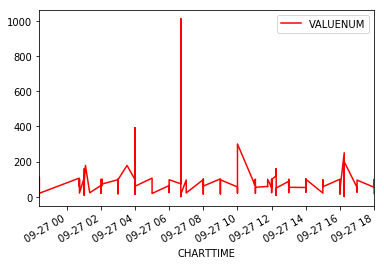

In [132]:
f, ax = plt.subplots(1)

df_test = df.filter(df.ICUSTAY_ID == '261926').select('CHARTTIME', 'VALUENUM')

pdf = df_test.toPandas()
pdf.plot(kind='line', x='CHARTTIME', y='VALUENUM', color='red', ax=ax)
plt.show()

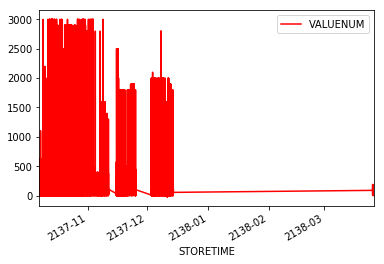

In [133]:
# histograms of items per patient
f, ax = plt.subplots(1)

df_patient = df.filter(df.SUBJECT_ID == '10694')\
                .select('STORETIME', 'VALUENUM')

df_p = df_patient.toPandas()
df_p.plot(kind='line', x='STORETIME', y='VALUENUM', color='red', ax=ax)
plt.show()